In [4]:
! pip install -q mne
%load_ext autoreload
%autoreload 2

In [6]:
# Run this notebook outside of main module tree
import os
import sys

nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)

In [122]:
from performance import *
from eeg_io import * 

timing = pd.read_csv("../eeg_tests/timing.csv")
eeg_data = "../data/EEG"

In [ ]:
# u = with_timing('P13', timing)
# df = u['stroop-text']

calc_accuracy = lambda d: ((d['Response Accuracy'] == 'rm_hit').sum() / 
                          d['Response Accuracy'].count())

df[df.Block == 'Main'].groupby(['Task', 'Condition']).apply(calc_accuracy)
df[df.Block == 'Main'].groupby(['Task', 'Condition']).median().RT

In [ ]:
perf_df = read_all_user_success(timing, eeg_data, targets = ['two-back', 'three-back'])

In [131]:
# https://github.com/statsmodels/statsmodels/issues/3931
from scipy import stats
stats.chisqprob = lambda chisq, df: stats.chi2.sf(chisq, df)

In [140]:
import re

def design_perf_df(df):
    d = df.copy()
    d = (perf_df
         .pivot_table(index=['user', 'test', 'metric'], values='score')
         .unstack(level=[1,2]))
    d.columns = ['_'.join(col).strip() for col in d.columns.values]
    d.index = [int(re.sub(r'[^\d]', '', s)) for s in d.index]
    d['treated'] = d.index > 23
    return d

In [ ]:
import statsmodels.api as sm

d = design_perf_df(perf_df)
X = d.dropna().drop('treated', 1)
y = d.dropna().treated

res = sm.Logit(y, X).fit().summary()
print(res)

In [142]:
# OLS REGRESSIONS ON EACH DEPENDENT VARIABLE OPTION

fit = lambda X,y: sm.OLS(X, sm.add_constant(y).astype(float)).fit()
fits = [fit(X[col], y) for col in X.columns]

In [ ]:
[print(f.summary()) for f in fits]

In [ ]:
# TWO-BACK PRECISION

print(fits[6].summary())
_ = sm.graphics.plot_fit(fits[6], 1)

                             OLS Regression Results                             
Dep. Variable:     three-back_precision   R-squared:                       0.253
Model:                              OLS   Adj. R-squared:                  0.237
Method:                   Least Squares   F-statistic:                     15.25
Date:                  Tue, 06 Mar 2018   Prob (F-statistic):           0.000313
Time:                          17:17:43   Log-Likelihood:                 27.649
No. Observations:                    47   AIC:                            -51.30
Df Residuals:                        45   BIC:                            -47.60
Df Model:                             1                                         
Covariance Type:              nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.6308      0.032

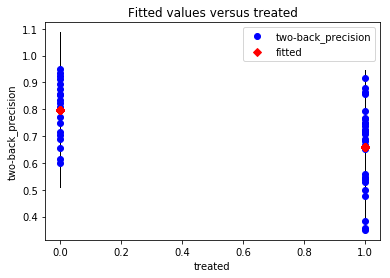

In [491]:
# TWO-BACK PRECISION

print(fits[2].summary())
_ = sm.graphics.plot_fit(fits[6], 1)

In [428]:
print(sm.RLM(X['two-back_precision'], sm.add_constant(y).astype(float)).fit().summary())
print(sm.RLM(X['three-back_precision'], sm.add_constant(y).astype(float)).fit().summary())

                    Robust linear Model Regression Results                    
Dep. Variable:     two-back_precision   No. Observations:                   47
Model:                            RLM   Df Residuals:                       45
Method:                          IRLS   Df Model:                            1
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Tue, 06 Mar 2018                                         
Time:                        16:56:40                                         
No. Iterations:                    17                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.7978      0.032     24.801      0.0

In [144]:
# BOOTSTRAP OLS

def sample_and_fit(df, col, target):
    df = df.sample(50, replace=True).dropna()
    f = fit(df[col], df[target])
    return f.params[target]

def bootstrap_OLS(df, exog, endog):
    params = [sample_and_fit(d, exog, endog) for i in range(200)]    
    return exog, np.mean(params), np.percentile(params, 2.5), np.percentile(params, 97.5)

p = [bootstrap_OLS(d, c, 'treated') for c in d.drop('treated', 1).columns]
bootstrap_df = pd.DataFrame(p, columns = ['Exogenous', 'Coef', '[0.025', '0.975]'])
bootstrap_df

                         Exogenous       Coef      [0.025      0.975]
0                  stroop_accuracy  -0.011450   -0.032105    0.010421
1                   stroop_med_res  54.681546  -12.688596  121.668925
2  three-back_med_res_time_correct -34.978543 -100.396505   21.550002
3    three-back_med_res_time_wrong -25.820173  -95.580236   34.737393
4             three-back_precision  -0.161251   -0.240352   -0.093548
5                three-back_recall  -0.056587   -0.139683    0.020662
6    two-back_med_res_time_correct  27.101783  -17.665491   72.343122
7      two-back_med_res_time_wrong -22.567876  -86.754950   47.320225
8               two-back_precision  -0.142229   -0.210858   -0.060594
9                  two-back_recall  -0.060274   -0.145616    0.018905

In [483]:
def plot_hist(d, col):
    return (d.pivot(values=col, columns='treated')
            .plot
            .hist(stacked=True, alpha=0.5, bins=15, title=col))

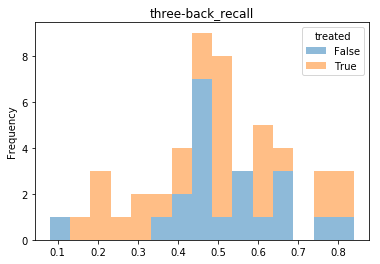

In [484]:
_ = plot_hist(d, 'three-back_recall')

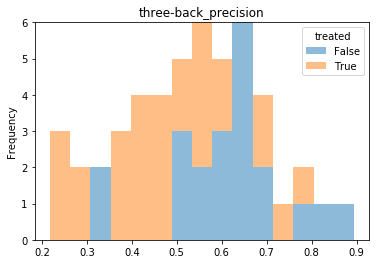

In [486]:
_ = plot_hist(d, 'three-back_precision')

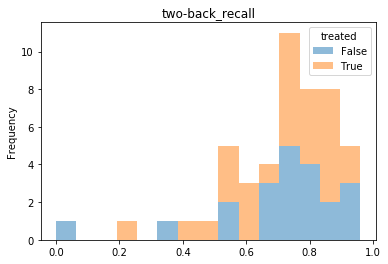

In [487]:
_ = plot_hist(d, 'two-back_recall')

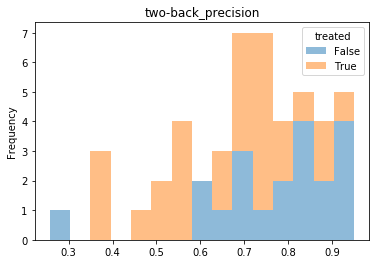

In [489]:
_ = plot_hist(d, 'two-back_precision')